In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import cv2
import json
import base64
import numpy as np
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
sys.path.append("..")

from src.config import (
    DATA_PATH,
    PROJECTION_DIM,
    SEED,
)

EMBEDDINGS_FILE_PATH = f"{DATA_PATH}/embeddings.json"
SKY_TYPES = ["clear", "partial", "overcast"]

In [3]:
# Read file
with open(EMBEDDINGS_FILE_PATH, "r") as f:
    embeddings_data = json.load(f)

# Convert to numpy array
embeddings = np.zeros((len(embeddings_data), PROJECTION_DIM))
embedding_sky_types = np.zeros((len(embeddings_data), 1))
for id, embedding_data in enumerate(embeddings_data.values()):
    sky_type = embedding_data["sky_type"]
    embedding = embedding_data["embedding"]
    embeddings[id] = np.array(embedding)
    embedding_sky_types[id] = SKY_TYPES.index(sky_type)

<Figure size 1000x1000 with 0 Axes>

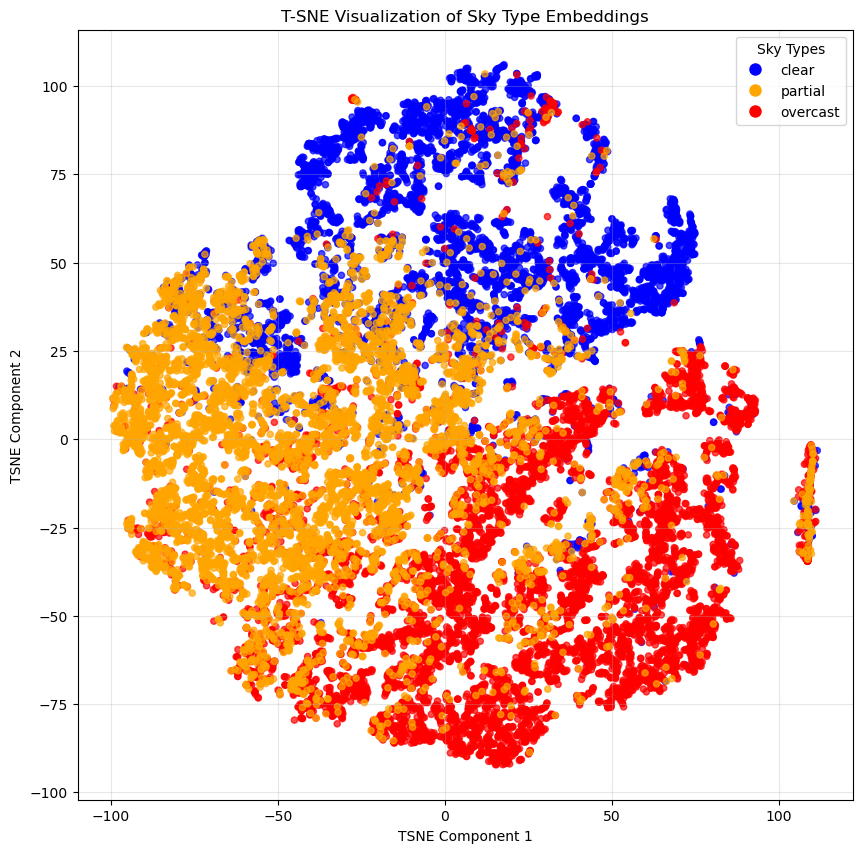

In [4]:
tsne = TSNE(n_components=2, random_state=SEED, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the 2D embeddings
colors = ["blue", "orange", "red"]
cmap = mcolors.ListedColormap(colors[:len(SKY_TYPES)])

plt.figure(figsize=(10, 10))
plt.figure(figsize=(10, 10))
scatter = plt.scatter(
    embeddings_2d[:, 0], 
    embeddings_2d[:, 1], 
    c=embedding_sky_types,  # Use class indices for coloring
    cmap=cmap,
    s=20,
    alpha=0.7
)

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                          markerfacecolor=colors[i], markersize=10, label=sky_type)
                 for i, sky_type in enumerate(SKY_TYPES)]
plt.legend(handles=legend_elements, title="Sky Types")

plt.title("T-SNE Visualization of Sky Type Embeddings")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.grid(True, alpha=0.3)
plt.show()

In [5]:
import numpy as np
from sklearn.manifold import TSNE
import cv2
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, CustomJS
from bokeh.layouts import column
from bokeh.models.widgets import Div
from bokeh.embed import file_html
from bokeh.resources import CDN
import json
import os
import base64
from PIL import Image
from io import BytesIO

def create_thumbnail(image_path, max_size=(250, 250)):
    """
    Create a data URI thumbnail from an image file
    """
    try:
        # Read the image
        img = cv2.imread(image_path)
        if img is None:
            return None
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize to thumbnail
        h, w = img.shape[:2]
        if h > w:
            new_h, new_w = max_size[0], int(w * max_size[0] / h)
        else:
            new_h, new_w = int(h * max_size[1] / w), max_size[1]
            
        img = cv2.resize(img, (new_w, new_h))
        
        # Convert to base64 data URI
        img_pil = Image.fromarray(img)
        buffer = BytesIO()
        img_pil.save(buffer, format="JPEG", quality=85)
        encoded_image = base64.b64encode(buffer.getvalue()).decode('utf-8')
        
        return f"data:image/jpeg;base64,{encoded_image}"
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def create_bokeh_tsne_plot(embeddings_data, sky_types, projection_dim, seed=42):
    """
    Create an interactive T-SNE plot with Bokeh that shows images on hover
    using data URIs instead of file paths
    """
    # Extract data from embeddings dictionary
    file_paths = list(embeddings_data.keys())
    embeddings = np.zeros((len(embeddings_data), projection_dim))
    sky_type_values = []
    
    print("Creating thumbnails for images...")
    # Pre-create thumbnails for all images
    thumbnails = {}
    for i, file_path in enumerate(file_paths):
        print(f"\rProcessing image {i+1}/{len(file_paths)}", end="")
        thumbnails[file_path] = create_thumbnail(file_path)
    print("\nFinished creating thumbnails.")
    
    # Extract embedding data
    for i, (file_path, data) in enumerate(embeddings_data.items()):
        if isinstance(data, dict):
            embedding = data["embedding"]
            sky_type = data["sky_type"]
        else:
            embedding = data
            # Try to extract sky type from filepath
            sky_type = None
            for t in sky_types:
                if t in file_path:
                    sky_type = t
                    break
        
        embeddings[i] = np.array(embedding)
        sky_type_values.append(sky_type)
    
    # Run T-SNE
    print("Running T-SNE...")
    tsne = TSNE(n_components=2, random_state=seed, perplexity=30)
    embeddings_2d = tsne.fit_transform(embeddings)
    print("T-SNE completed.")
    
    # Color each category differently
    colors = ['blue', 'orange', 'red']
    
    # Create a Bokeh figure
    p = figure(width=900, height=700, title="T-SNE Visualization with Image Hover",
               tools="pan,wheel_zoom,box_zoom,reset,save")
    
    # Create a div for displaying the image
    image_div = Div(width=300, height=300)
    
    # Add scatter points for each sky type with separate sources
    for i, sky_type in enumerate(sky_types):
        idx = [j for j, t in enumerate(sky_type_values) if t == sky_type]
        if not idx:
            continue
            
        sub_data = {
            'x': [embeddings_2d[j, 0] for j in idx],
            'y': [embeddings_2d[j, 1] for j in idx],
            'file_path': [file_paths[j] for j in idx],
            'sky_type': [sky_type_values[j] for j in idx],
            'filename': [os.path.basename(file_paths[j]) for j in idx],
            'thumbnail': [thumbnails[file_paths[j]] for j in idx],
        }
        
        sub_source = ColumnDataSource(data=sub_data)
        circle = p.circle('x', 'y', size=10, color=colors[i % len(colors)], 
                 legend_label=sky_type, alpha=0.7, source=sub_source)
        
        # Add callback for hover
        callback = CustomJS(args=dict(source=sub_source, div=image_div), code="""
            const indices = cb_data.index.indices;
            if (indices.length > 0) {
                const index = indices[0];
                const sky_type = source.data.sky_type[index];
                const file_name = source.data.filename[index];
                const thumbnail = source.data.thumbnail[index];
                
                // Update the div with image and info
                if (thumbnail) {
                    div.text = `
                        <div style="text-align: center; border: 1px solid #ddd; padding: 10px; border-radius: 5px;">
                            <img src="${thumbnail}" style="max-width: 250px; max-height: 250px;"><br>
                            <b>Type:</b> ${sky_type}<br>
                            <b>File:</b> ${file_name}
                        </div>
                    `;
                } else {
                    div.text = `
                        <div style="text-align: center; border: 1px solid #ddd; padding: 10px; border-radius: 5px;">
                            <p>Image not available</p>
                            <b>Type:</b> ${sky_type}<br>
                            <b>File:</b> ${file_name}
                        </div>
                    `;
                }
            }
        """)
        
        hover = HoverTool(tooltips=None, callback=callback, renderers=[circle])
        p.add_tools(hover)
    
    # Configure legend
    p.legend.title = "Sky Types"
    p.legend.location = "top_right"
    p.legend.click_policy = "hide"
    
    # Combine the plot and image div
    layout = column(p, image_div)
    
    # Return as HTML
    html = file_html(layout, CDN, "T-SNE Visualization with Image Hover")
    return html

# Example usage:
html_content = create_bokeh_tsne_plot(embeddings_data, SKY_TYPES, PROJECTION_DIM, SEED)
with open("tsne_interactive_plot.html", "w") as f:
    f.write(html_content)

Creating thumbnails for images...
Processing image 21490/21490
Finished creating thumbnails.
Running T-SNE...
T-SNE completed.
